## DQN Atari Breakout (using a Convolutional Neural Network)
This code is based on the *Lecture 6* from the excelent [course on Reinforcement Learning](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html) by David Silver.

It implements a Neural Network to learn the Atari game Breakout
TD learning with fixed Q-target and Experience Replay.

In [6]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import gym

from IPython.display import clear_output
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
%matplotlib inline

Number of possible actions: 4
Number of possible states: Box(210, 160, 3)


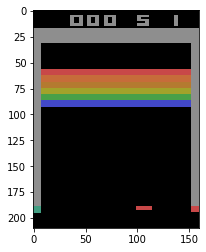

In [7]:
"""

""" 

ENV_NAME = "Breakout-v0"

env = gym.make(ENV_NAME)

print("Number of possible actions:", env.action_space.n)
print("Number of possible states:", env.observation_space)

env.reset()
plt.imshow(env.render("rgb_array"))

In [10]:
import numpy as np
import os
os.environ.setdefault('PATH', '')
from collections import deque
import gym
from gym import spaces
import cv2
cv2.ocl.setUseOpenCL(False)
from gym.spaces import Box
#from .wrappers import TimeLimit


class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)


class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, width=64, height=64, grayscale=True, dict_space_key=None):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.

        If the environment uses dictionary observations, `dict_space_key` can be specified which indicates which
        observation should be warped.
        """
        super().__init__(env)
        self._width = width
        self._height = height
        self._grayscale = grayscale
        self._key = dict_space_key
        if self._grayscale:
            num_colors = 1
        else:
            num_colors = 3

        new_space = gym.spaces.Box(
            low=0,
            high=255,
            #shape=(self._height, self._width, num_colors),
            shape=(num_colors, self._height, self._width),
            dtype=np.uint8,
        )
        if self._key is None:
            original_space = self.observation_space
            self.observation_space = new_space
        else:
            original_space = self.observation_space.spaces[self._key]
            self.observation_space.spaces[self._key] = new_space
        assert original_space.dtype == np.uint8 and len(original_space.shape) == 3

    def observation(self, obs):
        if self._key is None:
            frame = obs
        else:
            frame = obs[self._key]
            
        # crop for Breakout game
        frame = frame[54:193, 5:155]

        if self._grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(
            frame, (self._width, self._height), interpolation=cv2.INTER_AREA
        )
        if self._grayscale:
            #frame = np.expand_dims(frame, -1)
            frame = np.expand_dims(frame, 0)

        if self._key is None:
            obs = frame
        else:
            obs = obs.copy()
            obs[self._key] = frame
        return obs


class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.

        Returns lazy array, which is much more memory efficient.

        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        #shp = env.observation_space.shape
        n_channels, height, width = env.observation_space.shape
        shp = [n_channels*k, height, width]
        self.observation_space = Box(0.0, 1.0, shp)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.

        This object should only be converted to numpy array before being passed to the model.

        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            #self._out = np.concatenate(self._frames, axis=-1)
            self._out = np.concatenate(self._frames, axis=0)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

    def count(self):
        frames = self._force()
        return frames.shape[frames.ndim - 1]

    def frame(self, i):
        return self._force()[..., i]

def make_atari(env_id, max_episode_steps=None):
    env = gym.make(env_id)
    assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    if max_episode_steps is not None:
        env = TimeLimit(env, max_episode_steps=max_episode_steps)
    return env

def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env

def wrap_Breakout(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    env = MaxAndSkipEnv(env, skip=4)
    #if 'FIRE' in env.unwrapped.get_action_meanings():
    env = FireResetEnv(env)
    env = WarpFrame(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env

In [11]:
def make_env(seed=None):
    env = gym.make(ENV_NAME)
    if seed is not None:
        env.seed(seed)
    env = wrap_Breakout(env, episode_life=True, clip_rewards=True, frame_stack=True, scale=False)
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
print("Observation shape:", env.observation_space.shape)


Observation shape: (4, 64, 64)


/home/elisio/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


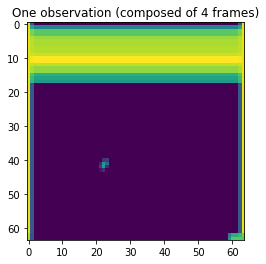

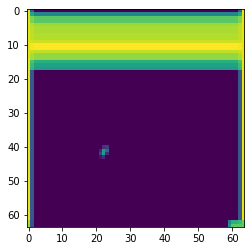

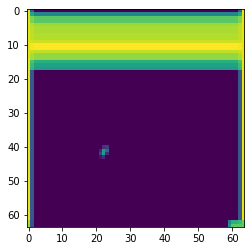

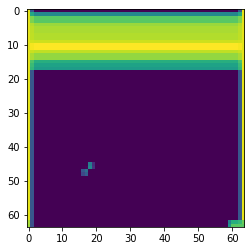

(4, 64, 64)


In [12]:
observ, _, _, _ = env.step(env.action_space.sample())

print("Observation shape:", env.observation_space.shape)
print()
plt.title("One observation (composed of 4 frames)")
plt.imshow(observ[0])
plt.show()
plt.imshow(observ[1])
plt.show()
plt.imshow(observ[2])
plt.show()
plt.imshow(observ[3])
plt.show()


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [14]:
class DQNAgent(nn.Module):
    def __init__(self, n_action_space, n_observation_space, epsilon):
        super().__init__()
        self.n_action_space = n_action_space
        self.n_observation_space = n_observation_space
        
        self.epsilon = epsilon
               
        # batch shape = batch_size x 4 x height x width
        # the 4 is due to the 4 frames that are processed at the same time
        # check MaxAndSkipEnv wrapper above
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=2), #in=4x64x64 out=16x31x31
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2), #in=16x31x31 out=32x15x15
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=1), #in=32x15x15 out=64x14x14
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2), #in=64x14x14 out=128x7x7
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(7*7*128, n_action_space),
            torch.nn.ReLU()
        )
        
    def forward(self, state):
        
        qvalues = self.network(state)

        return qvalues
    
    def get_action_epsilon_greedy(self, qvalues):    
        # the action returned either will be random or the greedy
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.n_action_space) # return a random action
        else: # else, be greedy
            action = np.argmax(qvalues)
        return action
   
    def get_greedy_action(self, qvalues):
            return np.argmax(qvalues)
    
    def get_qvalues(self, state):
        state = torch.tensor([state], dtype=torch.float, device=device) # add batch dimension (=1) to state
        return self.forward(state).cpu().detach().numpy()
   

In [15]:
def calculate_loss(state_batch, action_batch, new_state_batch, reward_batch, done_batch, discount_factor):
    # convert variables to tensor
    state_batch = torch.tensor(state_batch, dtype=torch.float, device=device)
    new_state_batch = torch.tensor(new_state_batch, dtype=torch.float, device=device)
    reward_batch = torch.tensor(reward_batch, dtype=torch.float, device=device)
    done_batch = torch.tensor(done_batch, dtype=torch.uint8, device=device)
    
    not_done_batch = 1 - done_batch

    # predict all q-values for current state
    all_qvalues_state = agent(state_batch)
    #print(state_batch.shape)
    #l

    # select the q_value for the agent action
    qvalue_state = all_qvalues_state[range(len(all_qvalues_state)), action_batch]
    
    # predict all q-values for the new state 
    all_qvalues_new_state = target(new_state_batch)

    # select the q-value for the new state for the action that maximises it, q'(s',amax)
    qvalue_new_state = torch.tensor([torch.max(all_qvalues_new_state[i]).item() for i in range(len(all_qvalues_new_state))],
                                     dtype=torch.float32, device=device)
    
    # for TD target if it's a terminal state (done == 1) the target receives only the value of the reward
    # not_done_batch is a vector that when multiplied by the value function does that job.
    td_target = reward_batch + discount_factor*qvalue_new_state*not_done_batch

    # loss = MSE (mean squared error) of TD error (Q-network - Q-learning targets)
    # the detach is a way to fix the target network by not having its gradients computed
    loss = F.mse_loss(qvalue_state, td_target.detach())

    return loss

In [16]:
def populate_memory(memory_size):
    
    state = env.reset()
    total_reward = 0.0
    
    for _ in range(memory_size):
        qvalues = agent.get_qvalues(state) # get qvalues for current state
        action = agent.get_action_epsilon_greedy(qvalues) # get action based on e-greedy policy
        
        new_state, reward, done, info = env.step(action)
        
        # record current step variables
        memory.push(state, action, new_state, reward, done)
            
        state = env.reset() if done else new_state
            
        total_reward += reward
        
    return total_reward

In [17]:
def validation_test(n_episodes=10):
    env_val = gym.make(ENV_NAME).env
    env_val = make_env()
    total_reward = []
    
    for _ in range(n_episodes):
        state = env_val.reset()
        done = False
        ep_rewards = 0.0
        
        while not done:
            qvalues = agent.get_qvalues(state) # get qvalues for current state
            action = agent.get_greedy_action(qvalues)
            new_state, reward, done, info = env_val.step(action)
            state = new_state
            
            ep_rewards += reward

        total_reward.append(ep_rewards)

    return np.mean(total_reward)

In [18]:
# https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
class ReplayMemory:
    def __init__(self, capacity):
        self._capacity = capacity
        self._memory = []
        self._position = 0
    
    def push(self, state, action, new_state, reward, done):
        if len(self._memory) < self._capacity:
            self._memory.append(None)
        self._memory[self._position] = (state, action, new_state, reward, done)
        self._position = (self._position + 1) % self._capacity
        
    # pop batchs for each variable
    def pop(self, batch_size):
        idxes = [random.randint(0, len(self._memory) - 1) for _ in range(batch_size)]
        st_all, ac_all, nst_all, rw_all, dn_all = [], [], [], [], []
        for i in idxes:
            sample = self._memory[i]
            st_t, ac_t, nst_t, rw_t, dn_t = sample
            # by not copying the data the training speeds up dramatically
            st_all.append(np.array(st_t, copy=False)) 
            ac_all.append(np.array(ac_t, copy=False))
            nst_all.append(np.array(nst_t, copy=False))
            rw_all.append(np.array(rw_t, copy=False))
            dn_all.append(np.array(dn_t, copy=False))
        return np.array(st_all), np.array(ac_all), np.array(nst_all), np.array(rw_all), np.array(dn_all)
   
    def __len__(self):
        return len(self._memory)

In [19]:
# hyperparameters
init_epsilon = 1
final_epsilon = 0.1

discount_factor = 0.99
memory_size = 10000
batch_size = 16

epochs = 3*10**6 # increase number

update_target_rate = 5000 # rate that the target network will be updated

agent = DQNAgent(n_action_space=env.action_space.n, 
                 n_observation_space=env.observation_space.shape, 
                 epsilon=init_epsilon).to(device) 

target = DQNAgent(n_action_space=env.action_space.n, 
                  n_observation_space=env.observation_space.shape, 
                  epsilon=init_epsilon).to(device)

target.load_state_dict(agent.state_dict())

memory = ReplayMemory(memory_size)

In [20]:
learning_rate = 0.0001
optimiser = torch.optim.Adam(agent.parameters(), lr=learning_rate)

In [21]:
# play some games to fill the memory
print("Memory size:", len(memory))
rewards = populate_memory(memory_size)
print("Memory size:", len(memory))
print("Rewards:", rewards)

Memory size: 0
Memory size: 10000
Rewards: 280.0


In [22]:
def optimize():    
    state_batch, action_batch, new_state_batch, reward_batch, done_batch = memory.pop(batch_size)
    
    loss = calculate_loss(state_batch, action_batch, new_state_batch, reward_batch, done_batch, discount_factor)
    
    loss.backward() # calculate the sum of gradients
    optimiser.step() # update model's parameters
    optimiser.zero_grad() # set gradients to zero
    
    return loss.detach().cpu().item()

Progress 0.67% (Epoch 20000 from 3000000) 	 epsilon 0.99


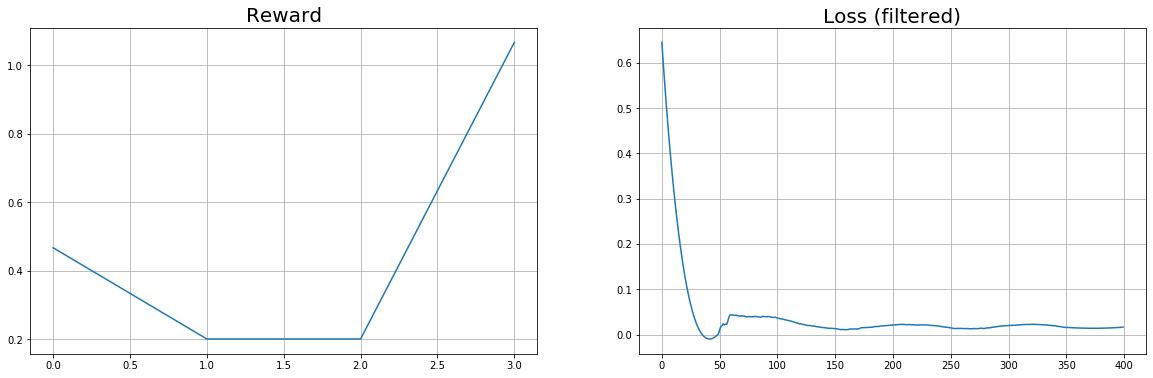

  1%|          | 22644/3000000 [04:15<9:08:03, 90.54it/s] 

KeyboardInterrupt: 

In [23]:
from tqdm import trange

state = env.reset()

total_loss = []
total_reward = []

# a constant to decrement the epsilon at each iteration
epsilon_discount_value = (init_epsilon-final_epsilon)/epochs

state = env.reset()

for epoch in trange(1, epochs+1):
    
    qvalues = agent.get_qvalues(state) # get qvalues for current state
    action = agent.get_action_epsilon_greedy(qvalues) # get action based on e-greedy policy

    new_state, reward, done, info = env.step(action)

    # record current step variables
    memory.push(state, action, new_state, reward, done)
    
    state = env.reset() if done else new_state
    
    loss = optimize()
   
   
    # save loss for plot
    if epoch % 50 == 0:
        total_loss.append(loss)
   
    # update epsilon
    agent.epsilon -= epsilon_discount_value
    
    # update target network with weights from 
    if epoch % update_target_rate == 0:
        target.load_state_dict(agent.state_dict())
        
    if epoch % 5000 == 0:
        total_reward.append(validation_test(n_episodes=3*5)) # 5 = number of lives of each episode
        
        clear_output(True)
        print("Progress {:.2f}% (Epoch {} from {}) \t epsilon {:.2f}".format(epoch*100/epochs, epoch, epochs, agent.epsilon))
        plt.figure(figsize=[20, 6])
        
        plt.subplot(1, 2, 1)
        plt.title("Reward", fontsize=20)
        plt.plot(total_reward)
        plt.grid()
        
        plt.subplot(1, 2, 2)
        plt.title("Loss (filtered)", fontsize=20) # Savitzky-Golay filter https://stackoverflow.com/a/20642478
        #print("len x:", len(total_loss))
        plt.plot(savgol_filter(total_loss, 99, 3))
        plt.grid()

        plt.show()

In [ ]:
# test trained agent
reward = validation_test(n_episodes=100) 
print("Reward for 100 games:", reward)

In [ ]:
reward = validation_test(n_episodes=30) 
print("Reward for 100 games:", reward)